## Collision 해결

In [1]:
import os
import numpy as np
from crewai import Agent, Task, Crew

os.environ["OPENAI_API_KEY"] = ""

from environment import Environment
import configs
import pickle

directiondict = {
    'Stay': 0, 'North': 1, 'South': 2, 'West': 3, 'East': 4, 'Stay.': 0, 'North.': 1, 'South.': 2, 'West.': 3, 'East.': 4 
}

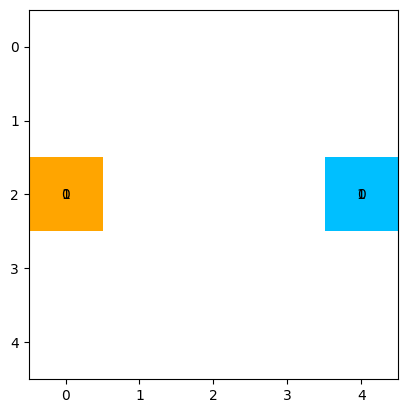

In [2]:
# Toy example 만들기(환경, 처음 위치, 목적지)
toy = (np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]), np.array([[2, 0], [2, 4]]), np.array([[2, 4], [2, 0]]))

env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

## 5X5 시야(FOV)를 가정

구현 순서 (open, 2명)
1. 두 명 이상의 에이전트가 서로의 시야에 들어온다
2. 두 에이전트의 숫자를 비교하여 작은 쪽이 정지하게 한다
3. 정지한 다른 에이전트를 장애물로 취급하고 큰 쪽이 navigate를 이어간다

구현 순서 (bottleneck, 2명)
1. 두 명 이상의 에이전트가 서로의 시야에 들어온다
2. 두 에이전트의 숫자를 비교하여 작은 쪽이 반대 방향으로 돌아가게 한다
3. 큰 쪽은 navigate를 이어간다
4. 쭉 주위 환경을 관찰하여 작은 쪽이 더이상 비키지 않아도 될 때 end.

한 달 동안 계속 해결해야 할 문제: 에이전트와 장애물이 복잡하게 섞인 상황에서 도대체 negotiator를 어떻게 설계할 것인지?

In [3]:
class PathFindingAgents():
	def path_finder(self, agent_number):
		return Agent(
			role='Path finder',
			goal='Start at the start point and reach the end point without crashing into a wall.',
			backstory=f"""You are a veteran adventurer with a great sense of direction.
			You understand which direction you need to move to get from where you are to where you want to go.
			Your agent number is {agent_number}.
			""",
			verbose=True
		)
    
	
# action에 stay 추가 필요.
class PathFindingTasks():
	def path_finding(self, agent, x, y, x_finish, y_finish, east, west, north, south, last_action):
		return Task(
  	description=(f"""
    Your current coordinates are ({x},{y}) and your destination is ({x_finish},{y_finish}).
    East and west in the coordinates correspond to the x axis.
    South and north in the coordinated correspond to the y axis.
    You can only move east, west, south and north or stay.
    So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
    You can only make one move at a time.
    {east}
    {west}
    {south}
    {north}
    Which direction do you move next?
    {last_action}
    Answer in one word only: {{DIRECTION}}
    """),
    expected_output='Direction',
    agent=agent
    )
	
  def negotiate(self, agent):
    return  Task(
		description=(f"""
    The agents who called you have numbers 0 and 1.
    """)
    )

In [4]:
agents = PathFindingAgents()
tasks = PathFindingTasks()

agent0 = agents.path_finder(0)
agent1 = agents.path_finder(1)

# 작업 필요
negotiator = Agent(
  role='Negotiator',
  goal="""Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.""",
  backstory="""You're a veteran overseer, and you've been called in to resolve the deadlock, as each agent is in the other's line of sight.
  To resolve the deadlock, you check each agent's number and only allow the agent with the largest number to act.
  """,
  verbose=True,
)

executor = Agent(
  role='Executor',
  goal="""Determine whether the deadlocked agents would collide with each other if they took their original planned moves, and if so, stop all but the agent with the largest number.""",
  backstory="""You're a veteran overseer, and you've been called in to resolve the deadlock, as each agent is in the other's line of sight.
  To resolve the deadlock, you check each agent's number and only allow the agent with the largest number to act.
  """,
  verbose=True,
)



> Entering new CrewAgentExecutor chain...


2024-06-03 19:00:13,025 - 28968 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


Given my current coordinates and the destination, I need to move along the x-axis (East-West direction) without changing my y-axis (North-South direction) because both my current and destination points have the same y-coordinate which is 2. Therefore, my direction of movement should be towards increasing x-coordinate.

Final Answer: East

> Finished chain.


> Entering new CrewAgentExecutor chain...
Considering my current position is (4,2) and my destination is (0,2), I need to move towards the west to decrease my x-coordinate. 

Final Answer: West

> Finished chain.


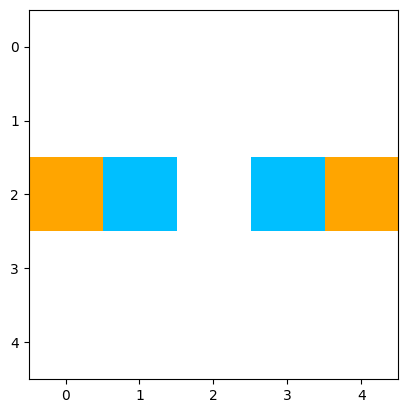

In [5]:
#에이전트들의 지난번 액션들
action_list0 = []
action_list1 = []

# 1 turn
for n in range(1):

  a0_obs = env.observe()[0][0][1]
  a1_obs = env.observe()[0][1][1]

  x0 = env.observe()[1][0][1]
  y0 = 4-env.observe()[1][0][0]
  x1 = env.observe()[1][1][1]
  y1 = 4-env.observe()[1][1][0]

  x0_finish = toy[2][0][1]
  y0_finish = 4-toy[2][0][0]
  x1_finish = toy[2][1][1]
  y1_finish = 4-toy[2][1][0]

  if a0_obs[4][3] == 0:
    west0 = """To your west lies a path."""
  else:
    west0 = """Your west is blocked by a wall."""

  if a0_obs[4][5] == 0:
    east0 = """To your east lies a path."""
  else:
    east0 = """Your east is blocked by a wall."""

  if a0_obs[5][4] == 0:
    south0 = """To your south lies a path."""
  else:
    south0 = """Your south is blocked by a wall."""

  if a0_obs[3][4] == 0:
    north0 = """To your north lies a path."""
  else:
    north0 = """Your north is blocked by a wall."""

  if len(action_list0) == 0:
    last_action0 = """"""
  elif action_list0[-1] in ['West', 'West.']:
    last_action0 = f"""You came from east."""
  elif action_list0[-1] in ['East', 'East.']:
    last_action0 = f"""You came from west."""
  elif action_list0[-1] in ['South', 'South.']:
    last_action0 = f"""You came from north."""
  elif action_list0[-1] in ['North', 'North.']:
    last_action0 = f"""You came from south."""
  elif action_list0[-1] in ['Stay', 'Stay.']:
    last_action0 = f"""You paused once for another agent."""
  else:
    last_action0 = """"""


  if a1_obs[4][3] == 0:
    west1 = """To your west lies a path."""
  else:
    west1 = """Your west is blocked by a wall."""

  if a1_obs[4][5] == 0:
    east1 = """To your east lies a path."""
  else:
    east1 = """Your east is blocked by a wall."""

  if a1_obs[5][4] == 0:
    south1 = """To your south lies a path."""
  else:
    south1 = """Your south is blocked by a wall."""

  if a1_obs[3][4] == 0:
    north1 = """To your north lies a path."""
  else:
    north1 = """Your north is blocked by a wall."""

  if len(action_list1) == 0:
    last_action1 = """"""
  elif action_list1[-1] in ['West', 'West.']:
    last_action1 = f"""You came from east."""
  elif action_list1[-1] in ['East', 'East.']:
    last_action1 = f"""You came from west."""
  elif action_list1[-1] in ['South', 'South.']:
    last_action1 = f"""You came from north."""
  elif action_list1[-1] in ['North', 'North.']:
    last_action1 = f"""You came from south."""
  elif action_list1[-1] in ['Stay', 'Stay.']:
    last_action1 = f"""You paused once for another agent."""
  else:
    last_action1 = """"""
  

  navigation0 = tasks.path_finding(agent0, x0, y0, x0_finish, y0_finish, east0, west0, north0, south0, last_action0)
  navigation1 = tasks.path_finding(agent1, x1, y1, x1_finish, y1_finish, east1, west1, north1, south1, last_action1)


  crew0 = Crew(
    agents=[agent0],
    tasks=[navigation0],
    verbose=0,
  )

  result0 = crew0.kickoff()

  action_list0.append(result0)

  crew1 = Crew(
    agents=[agent1],
    tasks=[navigation1],
    verbose=0,
  )

  result1 = crew1.kickoff()

  action_list1.append(result1)

  env.step([directiondict[result0], directiondict[result1]])
  env.render()

In [8]:
env.observe()[0][0][0]

array([[False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False,  True, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False]])

In [ ]:
#에이전트들의 지난번 액션들
action_list0 = []
action_list1 = []

# 1 turn
for n in range(1):

  a0_obs = env.observe()[0][0][1]
  a1_obs = env.observe()[0][1][1]

  x0 = env.observe()[1][0][1]
  y0 = 4-env.observe()[1][0][0]
  x1 = env.observe()[1][1][1]
  y1 = 4-env.observe()[1][1][0]

  x0_finish = toy[2][0][1]
  y0_finish = 4-toy[2][0][0]
  x1_finish = toy[2][1][1]
  y1_finish = 4-toy[2][1][0]

  if a0_obs[4][3] == 0:
    west0 = """To your west lies a path."""
  else:
    west0 = """Your west is blocked by a wall."""

  if a0_obs[4][5] == 0:
    east0 = """To your east lies a path."""
  else:
    east0 = """Your east is blocked by a wall."""

  if a0_obs[5][4] == 0:
    south0 = """To your south lies a path."""
  else:
    south0 = """Your south is blocked by a wall."""

  if a0_obs[3][4] == 0:
    north0 = """To your north lies a path."""
  else:
    north0 = """Your north is blocked by a wall."""

  if len(action_list0) == 0:
    last_action0 = """"""
  elif action_list0[-1] in ['West', 'West.']:
    last_action0 = f"""You came from east."""
  elif action_list0[-1] in ['East', 'East.']:
    last_action0 = f"""You came from west."""
  elif action_list0[-1] in ['South', 'South.']:
    last_action0 = f"""You came from north."""
  elif action_list0[-1] in ['North', 'North.']:
    last_action0 = f"""You came from south."""
  elif action_list0[-1] in ['Stay', 'Stay.']:
    last_action0 = f"""You paused once for another agent."""
  else:
    last_action0 = """"""


  if a1_obs[4][3] == 0:
    west1 = """To your west lies a path."""
  else:
    west1 = """Your west is blocked by a wall."""

  if a1_obs[4][5] == 0:
    east1 = """To your east lies a path."""
  else:
    east1 = """Your east is blocked by a wall."""

  if a1_obs[5][4] == 0:
    south1 = """To your south lies a path."""
  else:
    south1 = """Your south is blocked by a wall."""

  if a1_obs[3][4] == 0:
    north1 = """To your north lies a path."""
  else:
    north1 = """Your north is blocked by a wall."""

  if len(action_list1) == 0:
    last_action1 = """"""
  elif action_list1[-1] in ['West', 'West.']:
    last_action1 = f"""You came from east."""
  elif action_list1[-1] in ['East', 'East.']:
    last_action1 = f"""You came from west."""
  elif action_list1[-1] in ['South', 'South.']:
    last_action1 = f"""You came from north."""
  elif action_list1[-1] in ['North', 'North.']:
    last_action1 = f"""You came from south."""
  elif action_list1[-1] in ['Stay', 'Stay.']:
    last_action1 = f"""You paused once for another agent."""
  else:
    last_action1 = """"""
  

  navigation0 = tasks.path_finding(agent0, x0, y0, x0_finish, y0_finish, east0, west0, north0, south0, last_action0)
  navigation1 = tasks.path_finding(agent1, x1, y1, x1_finish, y1_finish, east1, west1, north1, south1, last_action1)


  crew0 = Crew(
    agents=[agent0],
    tasks=[navigation0],
    verbose=0,
  )

  result0 = crew0.kickoff()

  action_list0.append(result0)

  crew1 = Crew(
    agents=[agent1],
    tasks=[navigation1],
    verbose=0,
  )

  result1 = crew1.kickoff()

  action_list1.append(result1)

  env.step([directiondict[result0], directiondict[result1]])
  env.render()